<a href="https://colab.research.google.com/github/kacperwojtyniak/ml-playground/blob/main/Notebooks/Damaged_cars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 16.5MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 1.2MB 52.8MB/s 
     |████████████████████████████████| 194kB 50.7MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

Set bing key

In [ ]:
key = os.environ.get('AZURE_SEARCH_KEY', '')

Specify search terms

# Search for images

Search for images using Bing API. The `key` in the dictionary will be used as a name of the folder and category of the image. The `value` is a search term. The images will be downloaded. Maximum 150 images for each category.

In [ ]:
search_terms = {'damaged':'car dent', 'undamaged':'Mid-Size Car'}
path = Path('cars')

Download images

In [ ]:
if not path.exists():
  path.mkdir()
  
for k in search_terms:
  search_term = search_terms[k]
  dest = (path/k)
  dest.mkdir(exist_ok=True)
  results = search_images_bing(key, search_term) #max 150 images
  download_images(dest, urls=results.attrgot('contentUrl'))

Cleanup broken images as some of the downloaded files may be broken, not images, unable to open.

`failed` contains a list of files that are determined to be broken. `failed.map(Path.unlink);` deletes the files.

In [ ]:
fns = get_image_files(path)
failed = verify_images(fns)
failed

In [ ]:
failed.map(Path.unlink);

# Train

Path to the images downloaded outside this notebook. In this case it's a collection of about 4.5k images of cars.

In [11]:
 path = Path('gdrive/MyDrive/Colab Notebooks/datasets/cars_small')

Create datablock. Can think of it as a container for our data with settings for how to handle this data.

In [20]:
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=35),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.4))
dls = cars.dataloaders(path)

Show me a batch of images

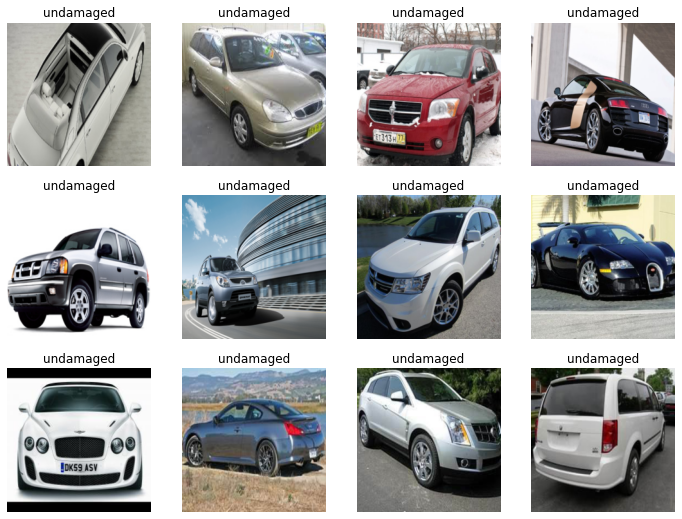

In [5]:
dls.valid.show_batch(max_n=12, nrows=3)

Let's see transforms assigned to one of the images

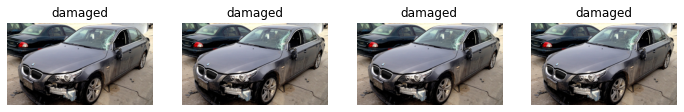

In [21]:
dls.train.show_batch(max_n=4, nrows=1, unique=True)

How big is the training set?

In [23]:
len(dls.train_ds)

501

How big is the validation set?

In [14]:
len(dls.valid_ds)

125

Create learner

In [24]:
learn = cnn_learner(dls, resnet50, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time


RuntimeError: ignored

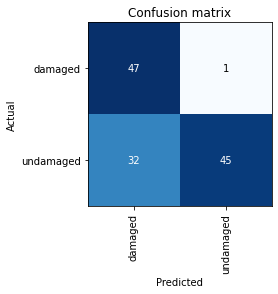

In [19]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [ ]:
learn.fine_tune(5)

In [ ]:
learn.export()

In [ ]:
path = Path()
learn_inf = load_learner(path/'export.pkl')

In [ ]:
test_url = 'https://ireland.apollo.olxcdn.com/v1/files/eyJmbiI6ImgxbTl3YzNsZmVwZTItT1RPTU9UT1BMIiwidyI6W3siZm4iOiJ3ZzRnbnFwNnkxZi1PVE9NT1RPUEwiLCJzIjoiMTYiLCJwIjoiMTAsLTEwIiwiYSI6IjAifV19.z-yaN24dt7FTMzsA02dm9O_-oMYEMyg9jnXNI-O6jjM/image;s=1080x720'
tst_dest = './tst.jpg'
download_url(test_url, tst_dest)

In [ ]:
learn_inf.predict('./tst.jpg')